In [1]:
import simpy
import random
import pandas as pd
import matplotlib.pyplot as plt


In [2]:
class BugTrackingSystem:
    def __init__(self, env, num_developers):
        self.env = env
        self.developers = simpy.Resource(env, capacity=num_developers)
        self.resolution_times = []
        self.bug_backlog = []
        self.backlog_stats = []
        self.total_developer_time = 0  # Track total time developers spend working
        self.num_developers = num_developers  # Store the number of developers


    def resolve_bug(self, bug_id, priority, severity):
        resolution_time = max(1, 10 - priority) * severity
        yield self.env.timeout(resolution_time)
        self.total_developer_time += resolution_time  # Accumulate developer time
        self.resolution_times.append({
            "Bug ID": bug_id,
            "Resolved Time": self.env.now,
            "Resolution Duration": resolution_time,
            "Priority": priority,
            "Severity": severity
        })

    def track_backlog(self):
        """Record the size of the backlog at each time step."""
        self.backlog_stats.append(len(self.bug_backlog))
        


In [3]:
def bug_generator(env, bug_tracking_system, arrival_rate, total_bugs):
    for i in range(total_bugs):
        priority = random.randint(1, 5)
        severity = random.uniform(1, 3)
        bug_tracking_system.bug_backlog.append((i, priority, severity))
        bug_tracking_system.track_backlog()  # Track backlog after adding a bug
        env.process(assign_bug(env, bug_tracking_system, i, priority, severity))
        yield env.timeout(random.expovariate(arrival_rate))

def assign_bug(env, bug_tracking_system, bug_id, priority, severity):
    with bug_tracking_system.developers.request() as request:
        yield request
        print(f"[{env.now}] Bug {bug_id} assigned: Priority={priority}, Severity={severity:.2f}")
        bug_tracking_system.bug_backlog.remove((bug_id, priority, severity))
        bug_tracking_system.track_backlog()  # Track backlog after resolving a bug
        yield env.process(bug_tracking_system.resolve_bug(bug_id, priority, severity))
        print(f"[{env.now}] Bug {bug_id} resolved")





In [4]:
def analyze_results(bug_tracking_system, start_time, end_time):
    data = pd.DataFrame(bug_tracking_system.resolution_times)
    if data.empty:
        print("No bugs were resolved.")
        return

    avg_resolution_time = data["Resolution Duration"].mean()
    print(f"\nAverage Resolution Time: {avg_resolution_time:.2f} units")
    avg_time_by_priority = data.groupby("Priority")["Resolution Duration"].mean()
    print("\nAverage Resolution Time by Priority:")
    print(avg_time_by_priority)

    plt.figure(figsize=(12, 6))
    plt.bar(data["Bug ID"], data["Resolution Duration"], color="skyblue", edgecolor="black")
    plt.xlabel("Bug ID")
    plt.ylabel("Resolution Time")
    plt.title("Bug Resolution Times")
    plt.grid(axis="y")
    plt.show()


    plt.figure(figsize=(8, 6))
    plt.scatter(data["Priority"], data["Resolution Duration"], color="orange", edgecolor="black")
    plt.xlabel("Bug Priority")
    plt.ylabel("Resolution Duration")
    plt.title("Bug Priority vs Resolution Duration")
    plt.grid()
    plt.show()

    # Plot backlog over time
    plt.figure(figsize=(12, 6))
    plt.plot(bug_tracking_system.backlog_stats, color="green", marker="o", linestyle='-', linewidth=2)
    plt.xlabel("Time Units")
    plt.ylabel("Backlog Size")
    plt.title("Backlog Size Over Time")
    plt.grid(True)
    plt.show()

    

    # Calculate and print total simulation time
    total_time = end_time - start_time
    print(f"\nTotal Simulation Time: {total_time:.2f} units")
    # Calculate and print developer utilization
    total_available_time = bug_tracking_system.num_developers * total_time
    utilized_time = bug_tracking_system.total_developer_time
    idle_time = total_available_time - utilized_time
    utilization = (utilized_time / total_available_time) * 100
    print(f"Developer Utilization: {utilization:.2f}%")

    # Plot developer utilization as a pie chart
    plt.figure(figsize=(8, 8))
    labels = 'Utilized Time', 'Idle Time'
    sizes = [utilized_time, idle_time]
    colors = ['lightcoral', 'lightskyblue']
    explode = (0.1, 0)  # explode the 1st slice (Utilized Time)

    plt.pie(sizes, explode=explode, labels=labels, colors=colors,
            autopct='%1.1f%%', shadow=True, startangle=140)
    plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
    plt.title("Developer Utilization")
    plt.show()


Starting Bug Tracking Simulation...

[0] Bug 0 assigned: Priority=1, Severity=1.05
[0.06432481281499311] Bug 1 assigned: Priority=2, Severity=1.28
[0.08595216959396902] Bug 2 assigned: Priority=5, Severity=1.17
[0.19556140147326723] Bug 3 assigned: Priority=1, Severity=1.19
[0.24852669238912076] Bug 4 assigned: Priority=5, Severity=1.05
[0.29286502622185684] Bug 5 assigned: Priority=5, Severity=1.84
[0.4121450134542623] Bug 6 assigned: Priority=3, Severity=2.62
[0.4134490071651157] Bug 7 assigned: Priority=2, Severity=2.40
[0.4966280244648319] Bug 8 assigned: Priority=2, Severity=1.43
[0.7849844738371408] Bug 9 assigned: Priority=1, Severity=1.19
[5.513886389227758] Bug 4 resolved
[5.513886389227758] Bug 10 assigned: Priority=3, Severity=2.21
[5.95534049588813] Bug 2 resolved
[5.95534049588813] Bug 11 assigned: Priority=4, Severity=2.07
[9.450193594008004] Bug 0 resolved
[9.450193594008004] Bug 12 assigned: Priority=4, Severity=1.16
[9.488063235838444] Bug 5 resolved
[9.488063235838444

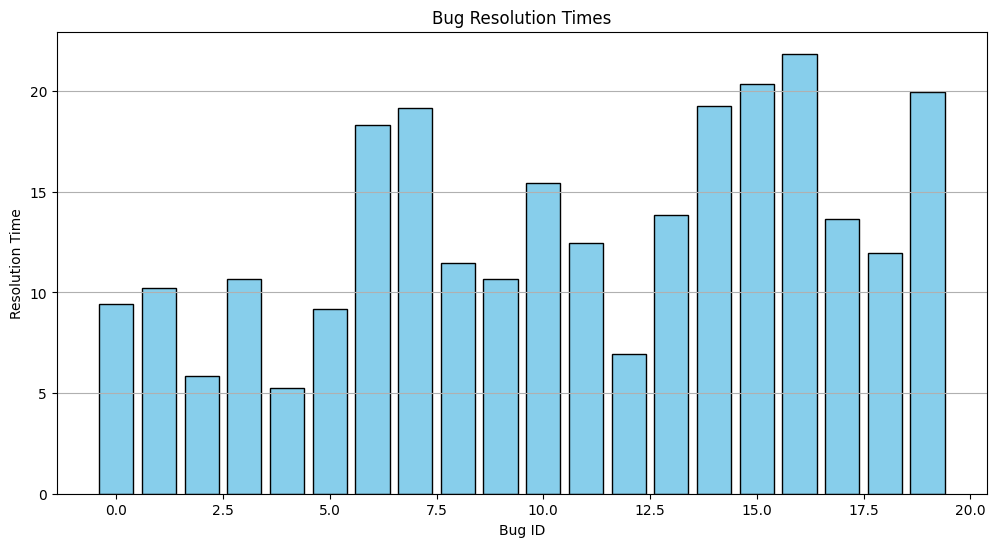

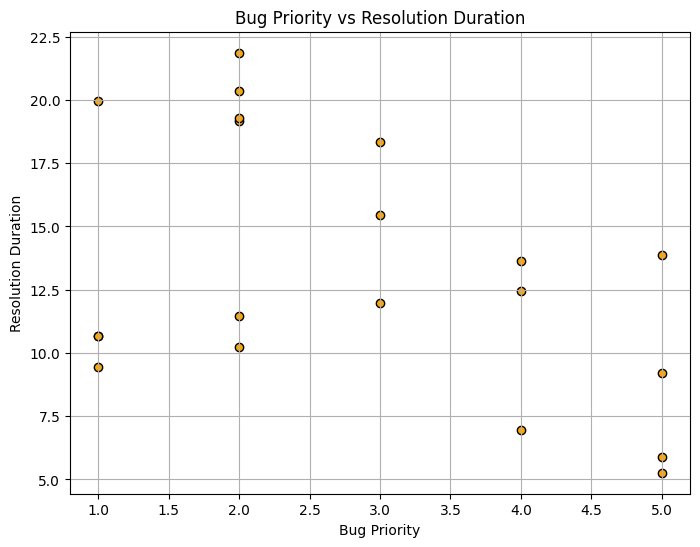

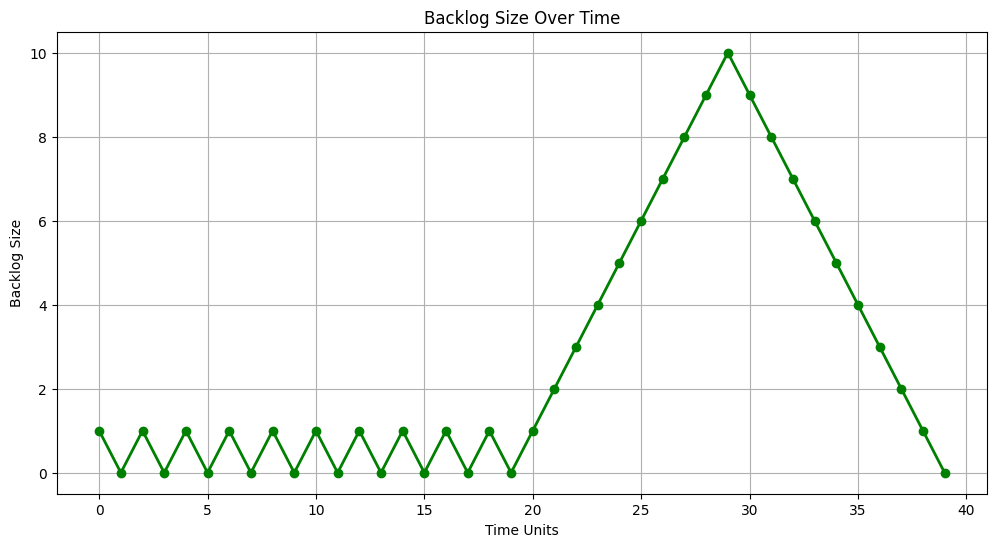


Total Simulation Time: 38.35 units
Developer Utilization: 69.37%


In [ ]:
# Simulation Parameters
RANDOM_SEED = 42
NUM_DEVELOPERS = 10
ARRIVAL_RATE = 5.0
TOTAL_BUGS = 20

random.seed(RANDOM_SEED)
env = simpy.Environment()
bug_tracking_system = BugTrackingSystem(env, NUM_DEVELOPERS)

print("Starting Bug Tracking Simulation...\n")
start_time = env.now
env.process(bug_generator(env, bug_tracking_system, ARRIVAL_RATE, TOTAL_BUGS))
env.run()
end_time = env.now

analyze_results(bug_tracking_system, start_time, end_time)
